In [1]:
import networkx as nx
import pandas as pd
from nf1 import *
import community
from networkx.algorithms.community import *
%pylab inline
%matplotlib inline
import seaborn as sns
from functools import *
from bokeh.io import output_notebook, show, save,output_file
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.bokeh.MultiPlot import MultiPlot
import scipy.stats as st
import demon as d
from pquality.PartitionQuality import pquality_summary
from pylab import rcParams
from collections import defaultdict
import json
import ndlib.models.epidemics.SISModel as sis
import ndlib.models.epidemics.SIModel as si
import ndlib.models.epidemics.ThresholdModel as th
import ndlib.models.ModelConfig as mc
from bokeh.models.annotations import Title
rcParams['figure.figsize'] = 7, 5
from collections import Counter
from itertools import chain

Populating the interactive namespace from numpy and matplotlib


Moreover, the statistics computed on the crawled data must be compared with
the ones of (i) random and (ii) preferential attachment graphs having the same
number of nodes.

In [2]:
df = pd.read_csv('dataset.csv', sep=",")
df.head()

,Source,Target,Weight,Timestamp
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


In [3]:
class Graph(object):
    
    df = pd.DataFrame()
    dfB = pd.DataFrame()
    dfC = pd.DataFrame()

    density = 0
        
    def __init__(self, g, name):
        self.g = g
        self.name = name
        self.degree() 
        self.N = g.order()
        self.E = g.size()
    def componentOverlap(self,p):
        inc, dec = p
        self.increasingoverlap = inc
        self.decreasingoverlap = dec
        
    def overlap(self,ov):
        self.overlapping_coefficient = ov
    
    def add_column(cln,data):
        self.df[cln] = Series(data, index=self.df.index)
    def lcoms(self,lcoms):
        self.lcoms = lcoms  
    def kcoms(self,kcoms):
        self.kcoms = kcoms      
    def dcoms(self,dcoms):
        self.dcoms = dcoms  
    def locoms(self,locoms):
        self.locoms = locoms   
    def avg (self):
         self.avg_deg = float(self.E)/self.N      
    def degree(self):
        self.degrees = sorted([ v for (k , v ) in self.g.degree()], reverse=True)
    def degreeCen(self,deg):
        self.degC = deg
    def betCen(self,deg):
        self.degB = deg
    def closeCen(self,deg):
        self.degClose = deg

In [4]:
df['Weight'] = (df['Weight']-min(df['Weight']))/(max(df['Weight'])-min(df['Weight']))
df.head()

,Source,Target,Weight,Timestamp
0,6,2,0.70,1.289242e+09
1,6,5,0.60,1.289242e+09
2,1,15,0.55,1.289243e+09
3,4,3,0.85,1.289245e+09
4,13,16,0.90,1.289254e+09


In [5]:
#ax = sns.distplot(df['Weight'], bins = 300)
#ax.set(xlabel='Degree', ylabel='Frequency')
n= 100

In [6]:
#!jupyter nbconvert --to script ARS_AnalyticsTask.ipynb

In [7]:
nt = nx.DiGraph(name="Bitcoin Over The Counter")
nt = nx.from_pandas_edgelist(df, source='Source', target='Target', edge_attr  =['Weight'])
g = nt.copy()
ER = nx.erdos_renyi_graph(nt.number_of_nodes(), 0.1)
BA = nx.barabasi_albert_graph(nt.number_of_nodes(), 3, seed=None)
graphs = []
graphs.append(Graph(g,"Bitcoin"))
graphs.append(Graph(ER, "Erdos Renyi"))
graphs.append(Graph(BA, "Barabasi Albert"))

In [73]:
def statistic(graph):
    """
    grap: network
    n_pieces: 
    """
    print("Nome rete analizzata: %s" % graph.name)
    print(nx.info(graph.g))
    print("Numero di self-loops",nx.number_of_selfloops(graph.g))
    #  print("Diametro:" , nx.diameter(graph.to_undirected(True)))
    graph.g.density = nx.density(graph.g)
    print("Densità:",graph.g.density)
    graph.avg()
    print("Avg_degree:", graph.avg_deg )
    print("Media gradi:", np.mean(graph.degrees))
    print("Moda gradi:",st.mode(graph.degrees))
    print("Mediana gradi:",np.median(graph.degrees))
    #  for s,t,attr in graph.edges(data=True):
   #     print(s,t,attr['Weight'])
def overlapping(graph):
    overlapping_coefficents = []
    for x, y in graph.g.edges():
        overlapping_coefficents.append((x, y, len(list(nx.common_neighbors(graph.g, x, y)))))
        overlapping_coefficents = sorted(overlapping_coefficents, key=lambda tup: tup[2])
    graph.overlap(overlapping_coefficents) 

In [108]:
#per grafi diretti
def degree_centrality(graph,str):
    def n_node_outdegree(g,out):
        return reduce(lambda c , n : c + 1 if g.out_degree( out ) < 1 else c , g.nodes()
                , 0)
    def n_node_outdegree(g,inner):
        return reduce(lambda c , n : c + 1 if g.in_degree( inner ) < 1 else c , g.nodes()
                , 0)
    print("Degree Centrality:")
    fun1 =  list(map(lambda x: graph.degree(x), graph.nodes()))
  #  fun2 =  list(map(lambda x: graph.out_degree(x), graph.nodes()))
  #  fun3 =  list(map(lambda x: graph.in_degree(x), graph.nodes()))
    plot_degree_distribution(fun1, str )
  #  plot_degree_distribution(fun2, "Out Degree Distribution" )
  #  plot_degree_distribution(fun3, "In Degree Distribution")

In order to easily explore these centrality metrics on our graph, let's create a function
that generically prints the top 10 nodes based on the centrality metric:

In [109]:
def nbest_centrality(graph, metric, n=100,
    attribute="centrality", **kwargs):
    centrality = metric(graph, **kwargs)
  #  nx.set_node_attributes(graph, centrality,attribute)
    degrees = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    #for idx, item in enumerate(degrees[0:10]):
     #   item = (idx+1,) + item
     #   print("%i. %s: %0.3f" % item)
    return degrees

In [8]:
def plotting(graph):
    graph = graph.to_undirected(True)
    nx.draw(graph)
    pos=nx.spring_layout(graph)
    # Find the center Node
    dmin=1
    ncenter=0
    for n in pos:
        x,y=pos[n]
        d=(x-0.5)**2+(y-0.5)**2
        if d<dmin:
            ncenter=n
            dmin=d
    p=nx.single_source_shortest_path_length(graph,ncenter)
    plt.figure(figsize=(8,8))
    nx.draw_networkx_edges(graph,pos,nodelist=[ncenter],alpha=0.4)
    nx.draw_networkx_nodes(graph,pos,nodelist=list(p.keys()),node_size=90,node_color=list(p.values()),cmap=plt.cm.Reds_r)
    plt.show()

In [9]:
def plot_degree_distribution (deg, str) :
    degs = {}
    for n in deg :
        if n not in degs :
            degs [ n ] = 0
        degs [ n ] += 1
    items = sorted(degs.items())
    fig = figure()
    ax = fig.add_subplot(111)
    ax.plot( [ v for (k ,v ) in items ],[ k for (k , v ) in items ],marker='o',linestyle="None")
    ax.set_xscale('log')
    ax.set_yscale( 'log')
    plt.title( str )
    plt.ylabel("#nodes")
    plt.xlabel("degree")
    fig.savefig ( str + "png " )

In [112]:
for obj in graphs:
    statistic(obj)
   # if(obj.name != "Bitcoin"):   #time required
       # print("Diametero", nx.diameter(obj.g.to_undirected(True)))

NameError: name 'statistic' is not defined

In [ ]:
for obj in graphs:
    overlapping(obj)

In [ ]:
for obj in graphs:
    print("Transivity:" ,nx.transitivity(obj.g.to_undirected(True)))
    print("Average clustering:" ,nx.average_clustering(obj.g.to_undirected(True)))

Degree Centrality:
Degree Centrality:
Degree Centrality:


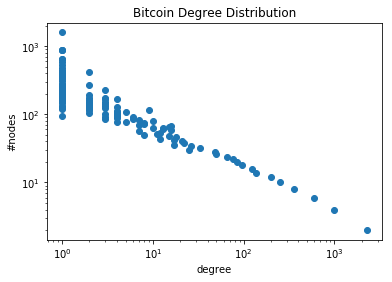

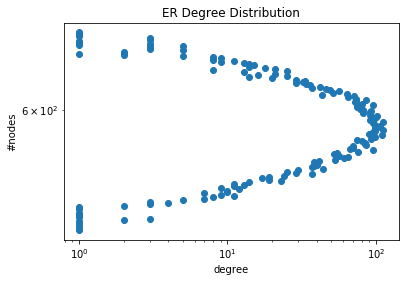

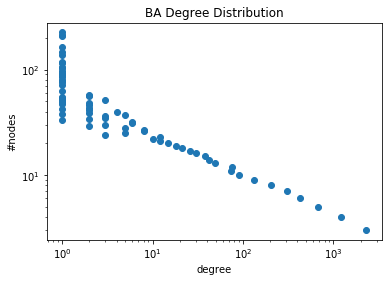

In [115]:
degree_centrality(graphs[0].g.to_directed(), "Bitcoin Degree Distribution")
degree_centrality(graphs[1].g, "ER Degree Distribution")
degree_centrality(graphs[2].g, "BA Degree Distribution")

In [116]:
#plotting(g)

In [10]:
def distributions_plotting(graphs): 
    plt.loglog(graphs[0].degrees, label=graphs[0].name, color='b',marker='o')
    plt.loglog(graphs[1].degrees, label=graphs[1].name, color='r',marker='o')
    plt.loglog(graphs[2].degrees, label=graphs[2].name, color='g',marker='o')
    plt.legend()
    plt.ylabel('DC')
    plt.xlabel('nodes')
    plt.savefig('degree_distribution.png', format='png')
    plt.close()

In [54]:
distributions_plotting(graphs)

Text(0.5,1,'Top 100 Degree')

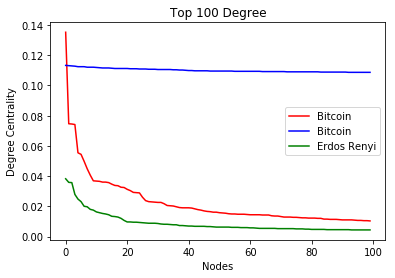

In [14]:
for obj in graphs:
    obj.degreeCen(nbest_centrality(obj.g, nx.degree_centrality))
fig = figure()
ax = fig.add_subplot(111)
ax.plot([  item[1] for idx, item in enumerate(graphs[0].degC[0:100])],'r-') # bitcoin
ax.plot([  item[1] for idx, item in enumerate(graphs[1].degC[0:100])],'b-') # Er
ax.plot([  item[1] for idx, item in enumerate(graphs[2].degC[0:100])],'g-') # Ba
plt.xlabel("Nodes")
plt.ylabel("Degree Centrality")
plt.legend([graphs[0].name,graphs[0].name,graphs[1].name])
plt.title("Top 100 Degree")

In [15]:
for obj in graphs:
    d = {'Nodo ' + obj.name: [ item[0]  for idx, item in enumerate(obj.degC)] ,
         'Grado': [  item[1] for idx, item in enumerate(obj.degC)],
         "Nodi": obj.degrees}
    df = pd.DataFrame(data=d)
    obj.df = df.set_index('Nodo ' + obj.name)

In [16]:
graphs[0].df.head()

,Grado Closeness,Nodi
Nodo Bitcoin,,
35.0,0.135204,795
1810.0,0.074660,439
2642.0,0.074490,438
2125.0,0.074150,436
2028.0,0.055442,326


In [17]:
graphs[1].df.head()

,Grado Closeness,Nodi
Nodo Erdos Renyi,,
5730,0.113265,666
3625,0.113095,665
5459,0.112925,664
1288,0.112755,663
1055,0.112415,661


In [18]:
graphs[2].df.head()

,Grado Closeness,Nodi
Nodo Barabasi Albert,,
3,0.038265,225
1,0.035884,211
2,0.035714,210
13,0.027891,164
18,0.024830,146


Note that this computation is extremely expensive and could take a long time
on your computer!

Text(0.5,1,'Top 100 Betweenness Degree')

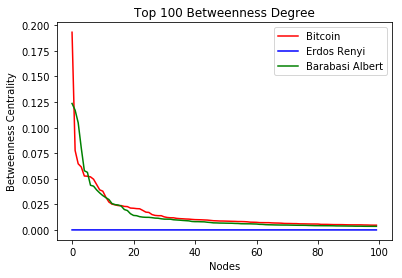

In [27]:
for obj in graphs:
    obj.betCen(nbest_centrality(obj.g, nx.betweenness_centrality, normalized=True))
fig = figure()
ax = fig.add_subplot(111)
ax.plot([  item[1] for idx, item in enumerate(graphs[0].degB[0:100])],'r-') # bitcoin
ax.plot([  item[1] for idx, item in enumerate(graphs[1].degB[0:100])],'b-') # Er
ax.plot([  item[1] for idx, item in enumerate(graphs[2].degB[0:100])],'g-') # Ba
plt.xlabel("Nodes")
plt.ylabel("Betweenness Centrality")
plt.legend([graphs[0].name,graphs[1].name,graphs[2].name])
plt.title("Top 100 Betweenness Degree")

In [28]:
for obj in graphs:
    d = {'Nodo ' + obj.name: [ item[0]  for idx, item in enumerate(obj.degB)] ,
         'Grado Betweenness': [  item[1] for idx, item in enumerate(obj.degB)]}
    df = pd.DataFrame(data=d)
    obj.dfB = df.set_index('Nodo ' + obj.name)

In [29]:
graphs[0].dfB.head()

,Grado Betweenness
Nodo Bitcoin,
35.0,0.193143
2125.0,0.077739
2642.0,0.064724
1810.0,0.061622
1.0,0.052810


In [30]:
graphs[1].dfB.head()

,Grado Betweenness
Nodo Erdos Renyi,
5730,0.000196
4149,0.000195
5459,0.000195
3625,0.000195
1288,0.000194


In [31]:
graphs[2].dfB.head()

,Grado Betweenness
Nodo Barabasi Albert,
3,0.123629
1,0.117080
2,0.104766
13,0.080143
7,0.057952


Text(0.5,1,'Top 100 Closeness Degree')

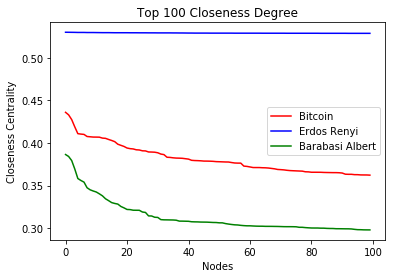

In [32]:
for obj in graphs:
    obj.closeCen(nbest_centrality(obj.g, nx.closeness_centrality))
fig = figure()
ax = fig.add_subplot(111)
ax.plot([  item[1] for idx, item in enumerate(graphs[0].degClose[0:100])],'r-') # bitcoin
ax.plot([  item[1] for idx, item in enumerate(graphs[1].degClose[0:100])],'b-') # Er
ax.plot([  item[1] for idx, item in enumerate(graphs[2].degClose[0:100])],'g-') # Ba
plt.xlabel("Nodes")
plt.ylabel("Closeness Centrality")
plt.legend([graphs[0].name,graphs[1].name,graphs[2].name])
plt.title("Top 100 Closeness Degree")

In [34]:
for obj in graphs:
    d = {'Nodo ' + obj.name: [ item[0]  for idx, item in enumerate(obj.degClose)] ,
         'Grado Closeness': [  item[1] for idx, item in enumerate(obj.degClose)]}
    df = pd.DataFrame(data=d)
    obj.dfC = df.set_index('Nodo ' + obj.name)

In [36]:
graphs[1].dfC.head()

,Grado Closeness
Nodo Erdos Renyi,
5730,0.530016
3625,0.529968
5459,0.529921
1288,0.529873
1055,0.529777


In [37]:
graphs[2].dfC.head()

,Grado Closeness
Nodo Barabasi Albert,
3,0.386486
1,0.384188
2,0.379379
13,0.369509
7,0.358318


In [ ]:
largest_cc = max(nx.connected_components(g), key=len)
print("Il componente piu largo della rete è largo :", len(largest_cc))

## Community

In [28]:
((graphs[0].g.remove_node(6000)) if graphs[0].g.has_node(6000) else 0)
((graphs[0].g.remove_node(3911)) if graphs[0].g.has_node(3911) else 0)
((graphs[0].g.remove_node(3762)) if graphs[0].g.has_node(3762) else 0)
((graphs[0].g.remove_node(6002)) if graphs[0].g.has_node(6002) else 0)
((graphs[0].g.remove_node(3912)) if graphs[0].g.has_node(3912) else 0)
((graphs[0].g.remove_node(3763)) if graphs[0].g.has_node(3763) else 0)

0

In [29]:
def printSummary(g,coms):
    res = pquality_summary(g, coms)
    for _, v in res.items():
        print(v)

## Louvain_Method

In [30]:
def louvain(g):
    part = community.best_partition(g)
    values = [part.get(node) for node in g.nodes()]
    nx.draw_spring(g, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
    print("%i partitions" % len(Counter(values).values()))
    result_dict = {0:[] , 1:[], 2:[], 3:[], 4:[], 5:[], 6 :[], 7:[], 8:[], 9:[], 10:[], 11:[], 12 :[], 13:[], 14:[], 15 :[], 16: [], 17: [], 18: []}
    for e,v in part.items():
        result_dict[v].append(e)
    locoms = result_dict.values()
    return locoms, part, values
def hist(values):
    numbins = len(Counter(values).values())
    plt.hist(values, bins=numbins,color="#0f6dbc")
    plt.title("Size of BitCoin Communities with Louvain")
    plt.xlabel("Community")
    plt.ylabel("Nodes")
def bubblechart(part):               
    parts = defaultdict(int)
    for parta in part.values():
        parts[parta] += 1
        bubbles = nx.Graph()
    for parta in parts.items():
        bubbles.add_node(parta[0], size=parta[1])
    pos = nx.random_layout(bubbles)
    plt.figure(figsize=(12,12))
    plt.axis('off')
    nx.draw_networkx_nodes(bubbles, pos,alpha=0.6, node_size=list(map(lambda x: x*6, parts.values())),node_color=[random.random() for x in parts.values()],cmap=plt.cm.RdYlBu)
    plt.show()
    printSummary(g,locoms)

In [ ]:
locoms, part,values = louvain(graphs[0].g)
graphs[0].locoms(locoms)
hist(values)

In [ ]:
bubblechart(part)

## Girvan_Newman

In [ ]:
def girvan(G):
    c = nx.connected_component_subgraphs(G)
    l = len(list(c))
    print("The number of connected component are {}".format(l))
    while (l < 3): 
        G.remove_edge(*edge_to_remove(G))    # sa qual'è l'edge da rimuovere
        c = nx.connected_component_subgraphs(G)
        l = len(list(c))
        print("The number of connected component are {}".format(l))
    return c

In [ ]:
def edge_to_remove(G):
    dict1 = nx.edge_betweenness_centrality(G)
    list_of_tuples = sorted(dict1.items(), reverse = True)
   # list_of_tuples.sort(key = lambda x: x[1], reverse =  true)
    return list_of_tuples[0][0]

In [ ]:
c = girvan(g)
printSummary(g,c)

## K-Clique

In [ ]:
def k_clique(g,rel = range(3,7)):
    k_cricche = {}
    for i in rel:
        k_cricche[i] = list(k_clique_communities(g.to_undirected(True), i))
        print("Grandezza componenti %s" % (len(k_cricche[i])))
        printSummary(g,k_cricche[i])
    return k_cricche

In [ ]:
k_cricche = k_clique(graphs[0].g)
graph[0].kcoms(k_cricche)

## Label Propagation

In [ ]:
lp = list(label_propagation_communities(g)
lpcoms = [tuple(x) for x in lp]
print("Numero community: %s " % len(lpcoms))
printSummary(g,lpcoms)
graph[0].lpcoms(lpcoms)

## Demon

In [ ]:
def demon(g,epsilon = np.arange(1,7)):
    coms = []
    for t in [x/10 for x in epsilon]:
        D = d.Demon(graph=g, epsilon=t)
        dcoms = D.execute()
        printSummary(g,dcoms)
        print("Grandezza componenti %s" % (len(dcoms)))
        coms.append((len(dcoms)))
    pm = plt.bar(epsilon, coms)
    ax.set_xticks(epsilon)
    ax.set_xticklabels([x/10 for x in epsilon])
    ax.set_ylim([0, 120])
    ax.set_ylabel('Community')
    ax.set_xlabel('Epsilon')

In [ ]:
dcoms = demon(graphs[0].g)
graph[0].dcoms(dcoms)

#  NF1

In [ ]:
# Computing the NF1 scores and statistics
nf = NF1(lpcoms, dcoms)
results = nf.summary()
print(results['scores'])
print(results['details'])

# Visualising the Precision-Recall density scatter-plot
nf.plot()

## Strong Ties

In [ ]:
def generate_triangles(nodes):
    """Generate triangles. Weed out duplicates."""
    visited_ids = set() # remember the nodes that we have tested already
    a = []
    for k, v in nodes.items(): #k --> v[node_b_id,...]
        for node_b_id in v:
            if node_b_id in visited_ids:
                continue # we should have already found (no come back)
            for node_c_id in nodes[node_b_id]:    #take all the neighbours od node_b
                if node_c_id in visited_ids:
                    continue # we should have already found c->a->b->c
                if k in nodes[node_c_id]:  #if k is in neighbours of node_c there is a triangle
                    a.append([k, node_b_id, node_c_id])  #nodes 6 2 10   yield in python instead of
        visited_ids.add(k) # don't search a - we already have all those cycles
    return a
nodesN = {}
for i in nx.nodes(g):
    nodesN[i] = [ n for n in g.neighbors(i) ]    #selezioni i nodi con più di due neighbours
#nodesN = dict([(k, v) for k, v in nodesN.items() if len(v) > 1])
a = generate_triangles(nodesN)
print("Numero triangoli %s" % len(a))
st = nx.triangles(nt)
print("Numero nodi con triangoli: %s" % len([k for k, v in st.items() if v > 0]))
#print("Media triangoli per nodo: %s" % [sum(st.values()) / len(st.keys())])

In [ ]:
def components_stats(g,n):
    print('computing number of components...')
    number_of_components = []
    for x,y, _ in n:
        number_of_components.append(nx.number_connected_components(g))
        e = (x,y)
        print(e)
        g.remove_edge(*(e))
    return number_of_components

def tie_strength(g):
    print('removing nodes in increasing order by common_neighbors')
    g_temp = deepcopy(g)
    number_of_components_increasing = components_stats(g_temp.g,g_temp.overlapping_coefficient)
    
    print('removing nodes in decreasing order by common_neighbors')
    g_temp = deepcopy(g)
    number_of_components_decreasing = components_stats(g_temp.g,list(reversed(g_temp.overlapping_coefficient)))
    plt.ylabel('Numero di componenti')
    plt.xlabel('Numero di link eliminati')
    plt.plot(number_of_components_increasing, label="Ordine crescente")
    plt.plot(number_of_components_decreasing, label="Ordine decrescente")
    plt.legend()
    plt.show()
    return (number_of_components_increasing,number_of_components_decreasing)

In [ ]:
#time required
graphs[0].componentOverlap(tie_strength(graphs[0]))

# Diffusion model to simulate
Specify the parameters 

In [ ]:
def simulateSI(graph,par):
    # Model Configuration
    g = graph.g
    vm = MultiPlot()
    for i in par:
        si_model = si.SIModel(g)
        config = mc.Configuration()
        config.add_model_parameter('beta', i)
        config.add_model_parameter("percentage_infected", 0.05)
        si_model.set_initial_status(config)
        iterations = si_model.iteration_bunch(200)
        trends = si_model.build_trends(iterations)
        viz = DiffusionTrend(si_model, trends)
        p4 = viz.plot(width=400, height=400)
        t = Title()
        t.text = graph.name
        p4.title = t
        vm.add_plot(p4)
    # Simulation
    print(json.dumps(si_model.parameters, indent=2))
    m = vm.plot()
 #   show(m)
    output_file(graph.name+'SI.html')
    save(m)
def simulateSIR(graph,par): 
    vm = MultiPlot()
    g = graph.g
    for i in par:
        sir_model = sir.SIRModel(g)
        config = mc.Configuration()
        config.add_model_parameter('beta', i[0])
        config.add_model_parameter('gamma', i[1])
        config.add_model_parameter("percentage_infected", i[2])
        sir_model.set_initial_status(config)
        iterations = sir_model.iteration_bunch(200)
        trends = sir_model.build_trends(iterations)
        viz = DiffusionTrend(sir_model, trends)
        p5 = viz.plot(width=400, height=400)
        t = Title()
        t.text = graph.name
        p5.title = t
        vm.add_plot(p5)
    print(json.dumps(sir_model.parameters, indent=2))
    m = vm.plot()
    #show(m)
    output_file(graph.name+'SIR.html')
    save(m)
def simulateSIS(graph,par): 
    vm = MultiPlot()
    g = graph.g
    for i in par:
        sis_model = sis.SISModel(g)
        config = mc.Configuration()
        config.add_model_parameter('beta', i[0])
        config.add_model_parameter('lambda', i[1] )
        config.add_model_parameter("percentage_infected",i[2])
        sis_model.set_initial_status(config)
        iterations = sis_model.iteration_bunch(200)
        trends = sis_model.build_trends(iterations)
        viz = DiffusionTrend(sis_model, trends)
        p3 = viz.plot(width=400, height=400)
        t = Title()
        t.text = graph.name
        p3.title = t
        vm.add_plot(p3)
    print(json.dumps(sis_model.parameters, indent=2))
    m = vm.plot()
  #  show(m)
    output_file(graph.name+'SIS.html')
    save(m)
def simulateThreshold(graph): 
    vm = MultiPlot()
    g = graph.g
    # Threshold
    th_model = th.ThresholdModel(g)
    config = mc.Configuration()
    # Set individual node threshold
    threshold = 0.40
    for n in g.nodes():
            config.add_node_configuration("threshold", n, threshold)
    config.add_model_parameter("percentage_infected", 0.30)
    th_model.set_initial_status(config)
    iterations = th_model.iteration_bunch(60)
    trends = th_model.build_trends(iterations)
    viz = DiffusionTrend(th_model, trends)
    p6 = viz.plot(width=400, height=400)
    t = Title()
    t.text = graph.name
    p6.title = t
    vm.add_plot(p6)
    m = vm.plot()
    #show(m)
    output_file(graph.name+'Threshold.html')
    save(m)   

In [ ]:
for obj in graphs:
    simulateSI(obj,[0.01,0.05, 0.1])
    simulateSIR(obj,[[0.005,0.01,0.05],[0.005,0.01,0.01],[0.005,0.006,0.01]])
    simulateSIS(obj,[[0.001,0.01,0.05],[0.01, 0.007, 0.05],[0.001,0.002,0.05]])
    simulateThreshold(obj)